Parameters to set:

up, down, left, right

thresh_corr_diff


## Images

In [336]:
import heapq
import os
import sys
import numpy as np
import pandas as pd
from skimage import io, img_as_float32
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.segmentation import find_boundaries
from scipy import ndimage
from skimage import exposure
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os, sys
sys.path.append("../bardensr")
import bardensr
import bardensr.plotting
from DeCRISP import decrisp as dcp
# import cv2
import tifffile as tif

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [337]:
n_channels = 2
n_cycles = 5

In [338]:
with open('./data/registered20210714_sg2NEB.npy', 'rb') as f:
    X = np.load(f)
# img = tif.imread('./data/registered20210714/amp-ch1-cycle1.tiff')
# img_size = img.shape[:2]

# X = np.zeros((n_channels*n_cycles, 1, *img_size))
# k = 0
# for i in range(n_channels):
#     for j in range(n_cycles):
#         fn = f'./data/registered20210714/amp-ch{i+1}-cycle{j+1}.tiff'
#         print(fn)
#         img = tif.imread(fn)
#         X[k, 0, :, :] = img[:, :, 1]  # using layer 1 out of layers 0-3
#         k = k+1

In [339]:
X.shape

(10, 1, 2048, 1280)

In [340]:
# for i in range(X.shape[0]):
#     plt.figure(dpi=250)
#     plt.imshow(X[i, 0,])

In [341]:
up = 10
down = 1800
left = 30
right = 1140

Xcenter = dcp.remove_border(X, up=up, down=down, left=left, right=right)

In [342]:
# for i in range(Xcenter.shape[0]):
#     plt.figure(dpi=250)
#     plt.imshow(Xcenter[i, 0,])

## Codebook

The most important is to make sure the codebook and the images are of the same order

In [343]:
codebook = pd.read_csv('./data/CRISPRmap_pilot_codebook_default.csv', dtype=np.int, header=None)
codebook = np.array(codebook)
codebook

array([[1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 1, 0, 0]])

In [344]:
codebook.shape

(10, 10)

## Background subtraction

In [345]:
Xcenter.shape

(10, 1, 1790, 1110)

In [346]:
# imp = np.zeros((21, 21))
# imp[10, 10] = 1
# f_imp = ndimage.gaussian_filter(imp, sigma=3)
# np.set_printoptions(linewidth=120, precision=3)
# np.max(f_imp)
# # np.sum(f_imp)

In [347]:
Xnorm = bardensr.preprocessing.background_subtraction(Xcenter, [0,11,11])
# Xnorm = Xcenter.copy()
# for i in range(Xcenter.shape[0]):
#     Xnorm[i, 0] = ndimage.maximum_filter(Xcenter[i, 0], size=(3, 3))
# Xnorm = Xcenter.copy()
# # Xnorm = bardensr.preprocessing.minmax(Xnorm)
# # alpha = 90
# for i in range(Xcenter.shape[0]):
# #     print(i, np.min(Xnorm[i, 0, ]), np.max(Xnorm[i, 0, ]))
#     blurred = ndimage.gaussian_filter(Xcenter[i, 0, ], sigma=5)
# #     blurred = ndimage.gaussian_filter(Xnorm[i, 0, ], sigma=3)
# #     print(i, np.min(blurred), np.max(blurred))
    
# #     filter_blurred = ndimage.gaussian_filter(blurred, 1)
#     Xnorm[i, 0, ] = np.abs(Xnorm[i, 0, ] - blurred)
# #     print(i, np.min(Xnorm[i, 0, ]), np.max(Xnorm[i, 0, ]))
# #     Xnorm[i, 0, ] = np.abs(blurred + alpha * (blurred - filter_blurred))
# #     Xnorm[i, 0, ] = np.abs(Xnorm[i, 0, ] + alpha * (blurred - filter_blurred))

Xnorm = bardensr.preprocessing.minmax(Xnorm)

# for i in range(Xcenter.shape[0]):
#     norm = cv2.normalize(Xnorm[i, 0], None, norm_type=cv2.NORM_INF)
#     Xnorm[i, 0] = norm

In [348]:
np.min(Xnorm)

0.0

In [349]:
Xnorm.shape

(10, 1, 1790, 1110)

In [350]:
# for i in range(Xnorm.shape[0]):
#     plt.figure(dpi=100)
#     fig, axes = plt.subplots(ncols=2, figsize=(18, 18))
#     ax = axes.ravel()

#     ax[0].imshow(Xcenter[i, 0])
#     ax[0].set_title('Before')

#     ax[1].imshow(Xnorm[i, 0])
#     ax[1].set_title('After')

#     for a in ax:
#         a.axis('off')

#     plt.show()

## Thresholding

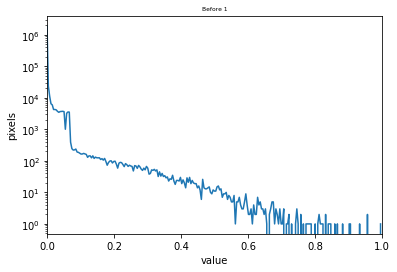

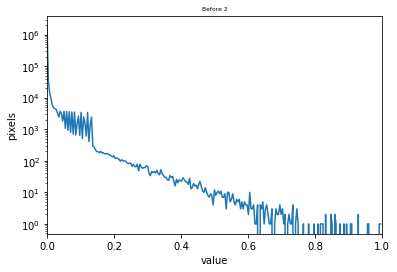

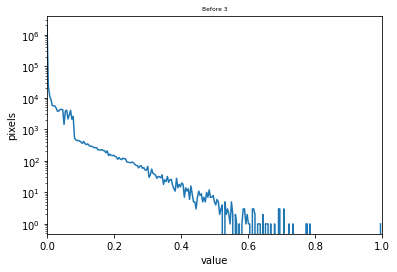

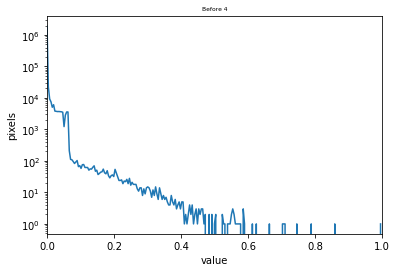

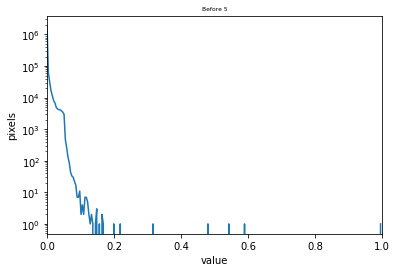

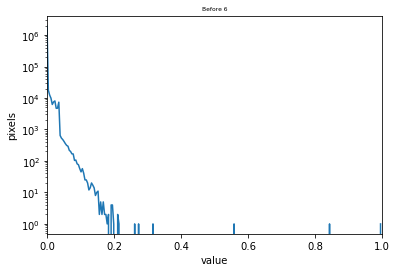

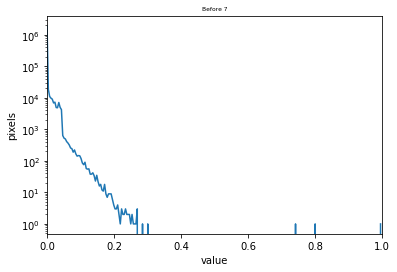

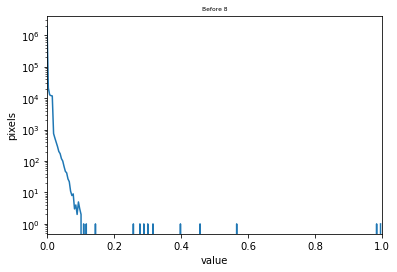

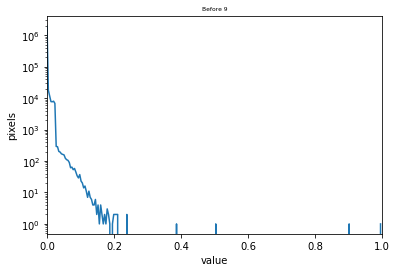

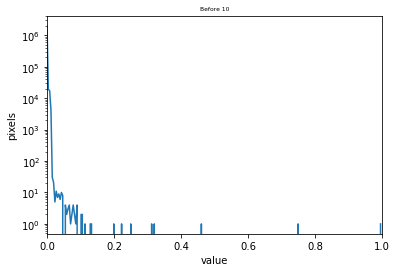

In [351]:
# Distributions before thresholding
for i in range(Xnorm.shape[0]):
    histogram, bin_edges = np.histogram(Xnorm[i, 0, ], bins=256, range=(0, 1))
    plt.figure()
    plt.title(f"Before {i+1}", fontsize=6)
    plt.xlabel("value")
    plt.ylabel("pixels")
    plt.semilogy(bin_edges[0:-1], histogram)
    plt.xlim([0.0, 1.0])
    plt.show()

In [365]:
Xthresh = Xnorm.copy()
for i in range(Xthresh.shape[0]):
    Xthresh[i, 0] = exposure.match_histograms(Xnorm[i, 0], Xnorm[1, 0])  # match histogram to Xnorm[1, 0]

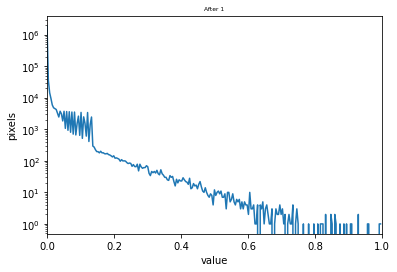

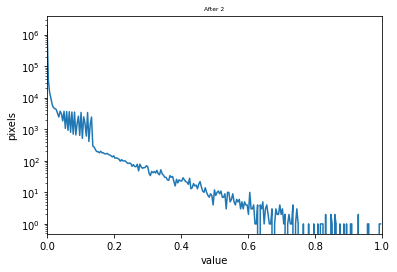

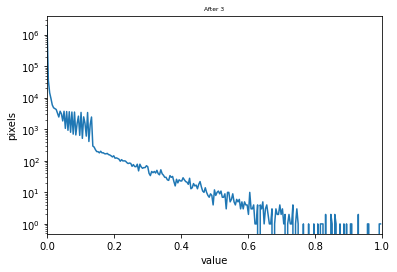

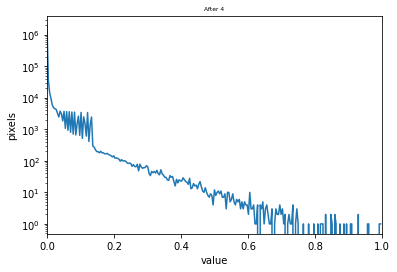

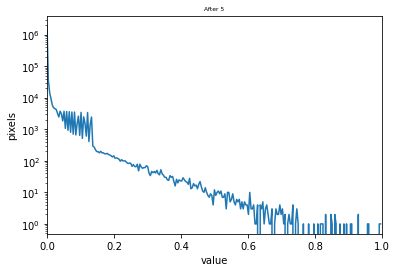

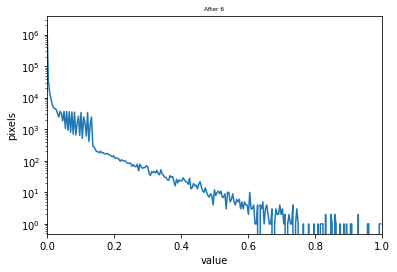

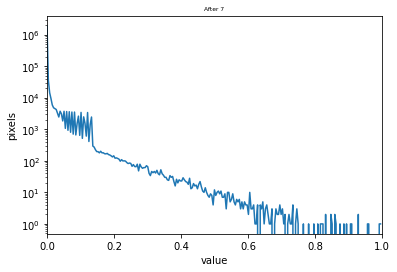

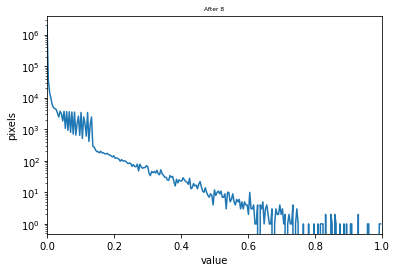

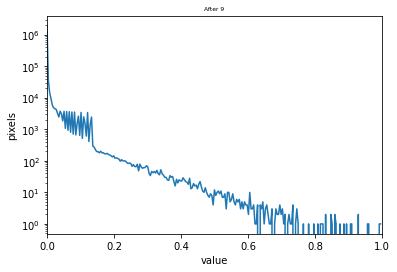

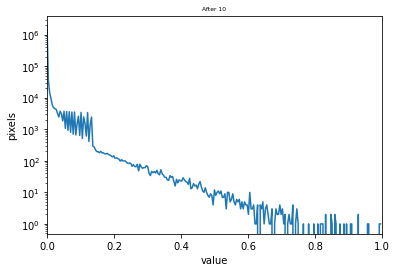

In [366]:
# Don't split this cell
# upper = dcp.upper_thresh(Xnorm, n_channels=n_channels, n_cycles=n_cycles, min_bin=5)
# Xthresh = dcp.upper_collapse(Xnorm, upper)
# Xthresh = bardensr.preprocessing.minmax(Xthresh)

# After
for i in range(Xthresh.shape[0]):
    histogram, bin_edges = np.histogram(Xthresh[i, 0, ], bins=256, range=(0, 1))
    plt.figure()
    plt.title(f"After {i+1}", fontsize=6)
    plt.xlabel("value")
    plt.ylabel("pixels")
    plt.semilogy(bin_edges[0:-1], histogram)
    plt.xlim([0.0, 1.0])
    plt.show()

# Xthresh = dcp.lower_thresh(Xthresh)
# residual = 0.01
# Xthresh[Xthresh < residual] = 0
# Xthresh = Xthresh > residual

<Figure size 600x400 with 0 Axes>

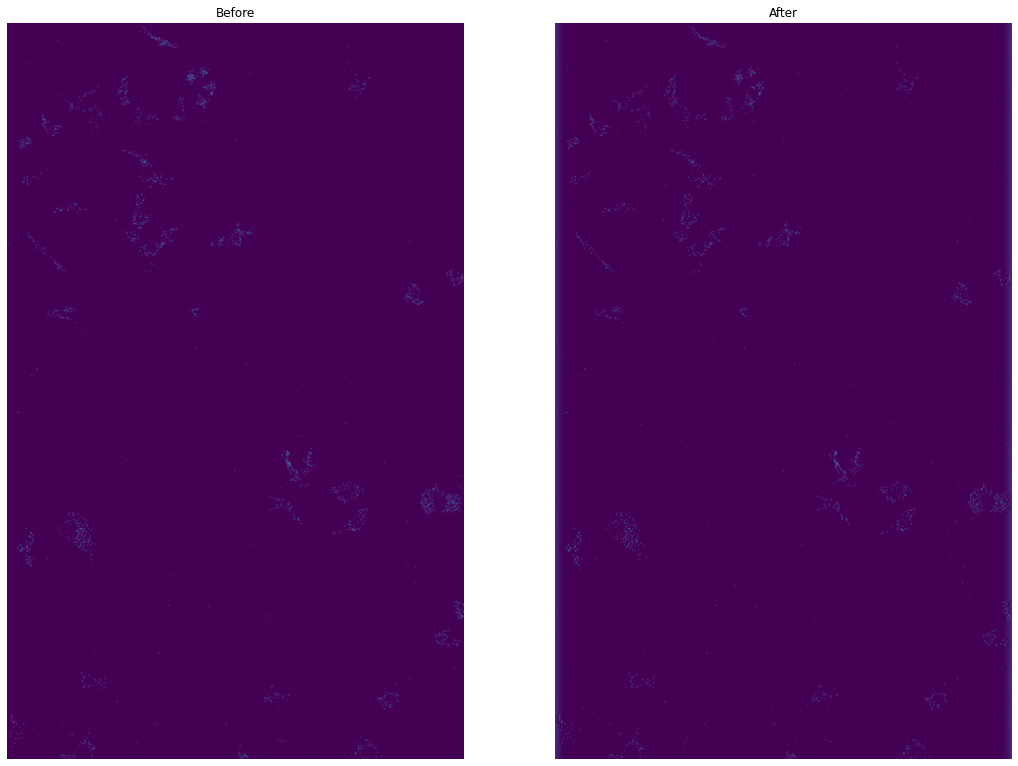

<Figure size 600x400 with 0 Axes>

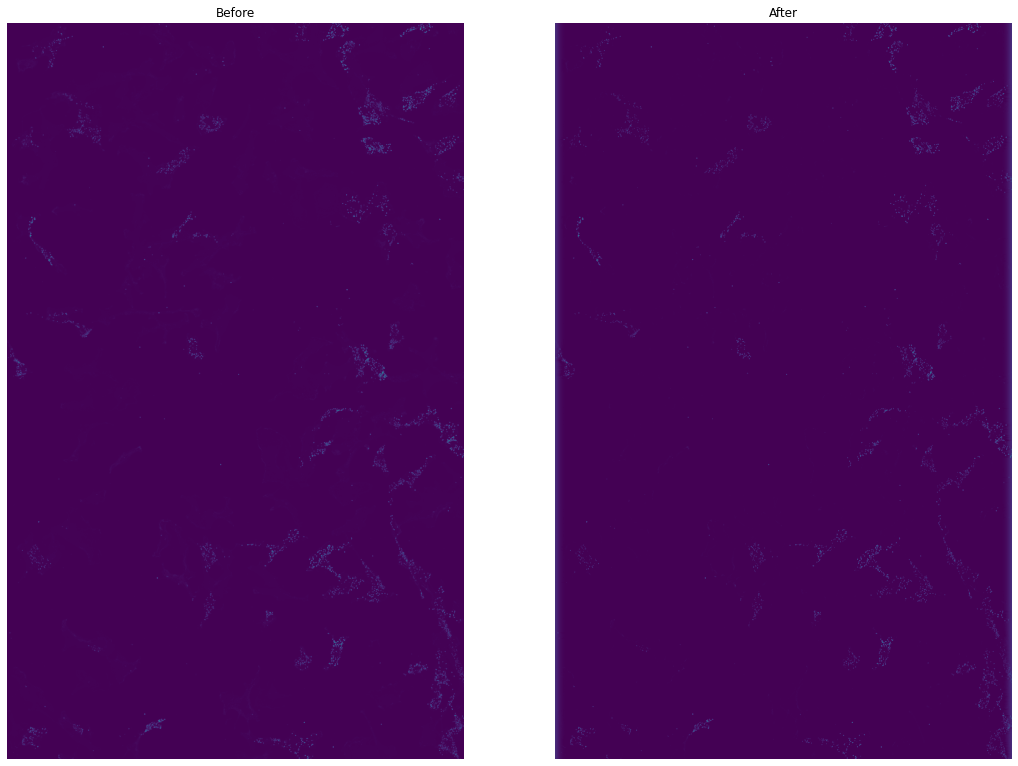

<Figure size 600x400 with 0 Axes>

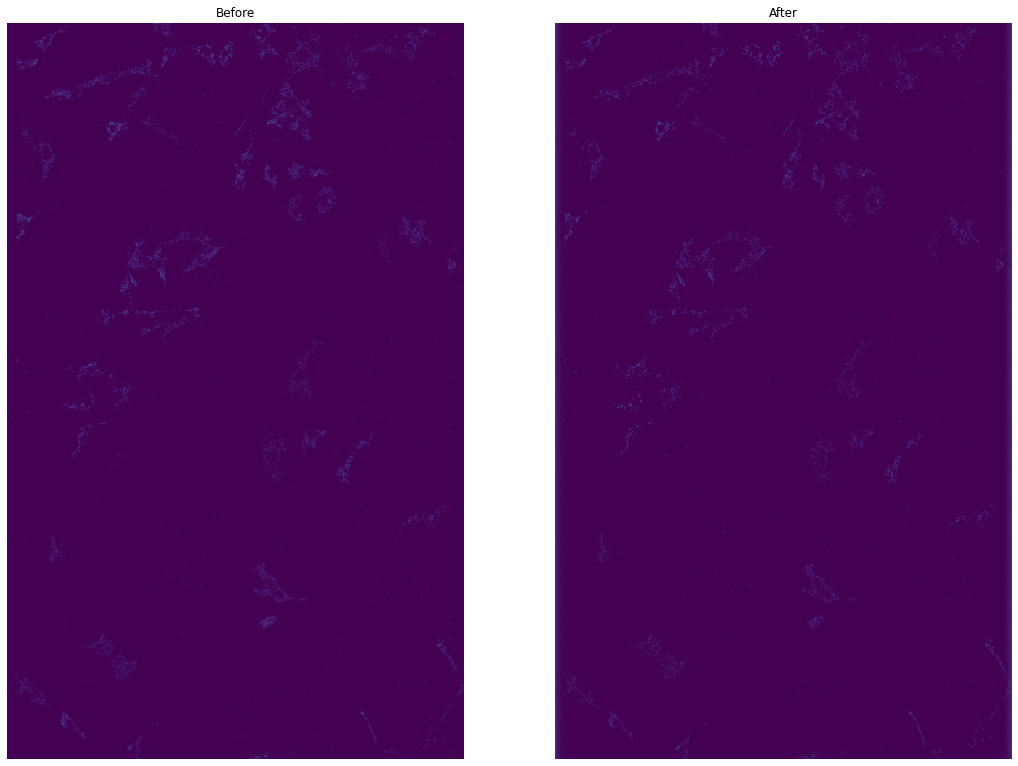

<Figure size 600x400 with 0 Axes>

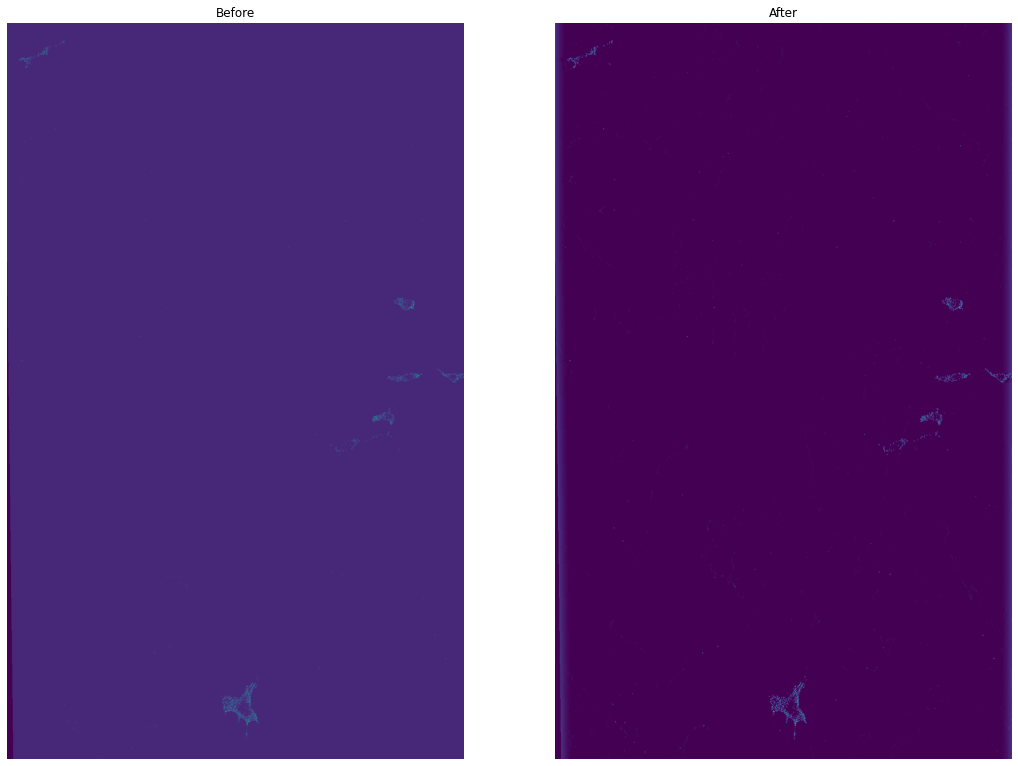

<Figure size 600x400 with 0 Axes>

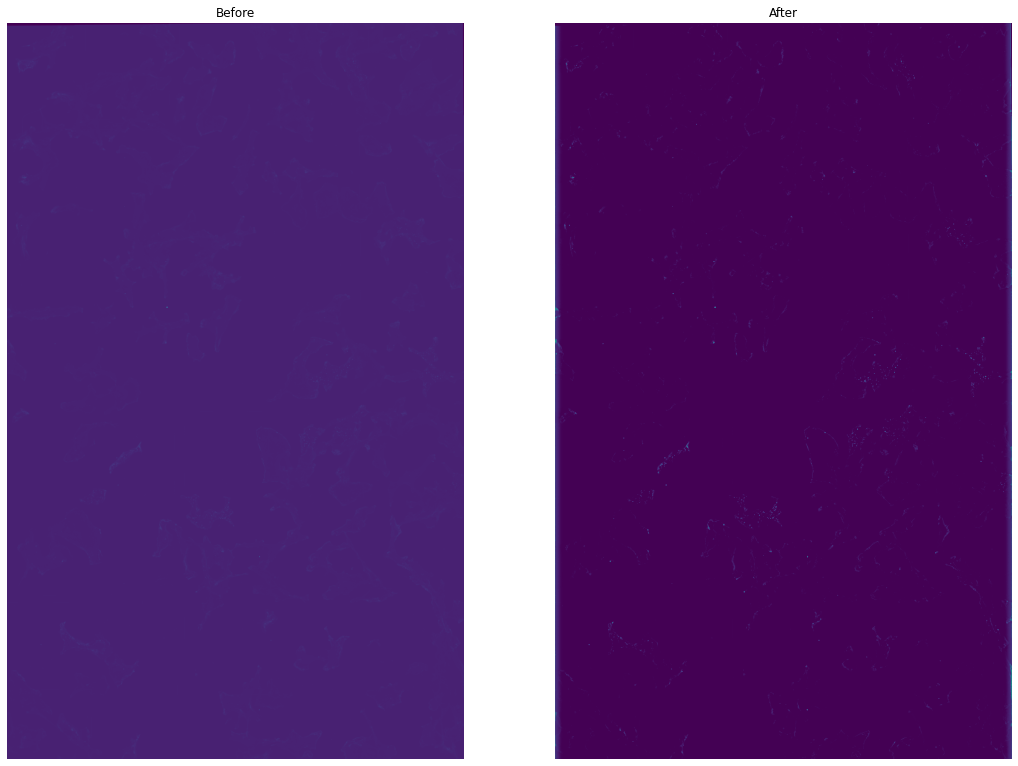

<Figure size 600x400 with 0 Axes>

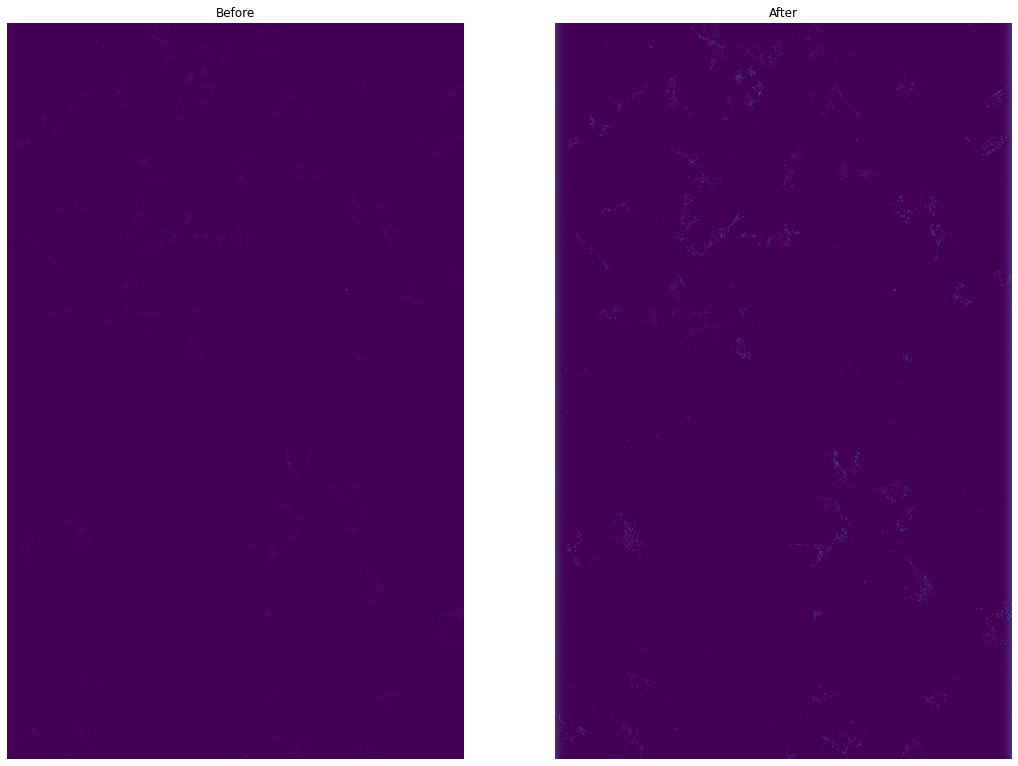

<Figure size 600x400 with 0 Axes>

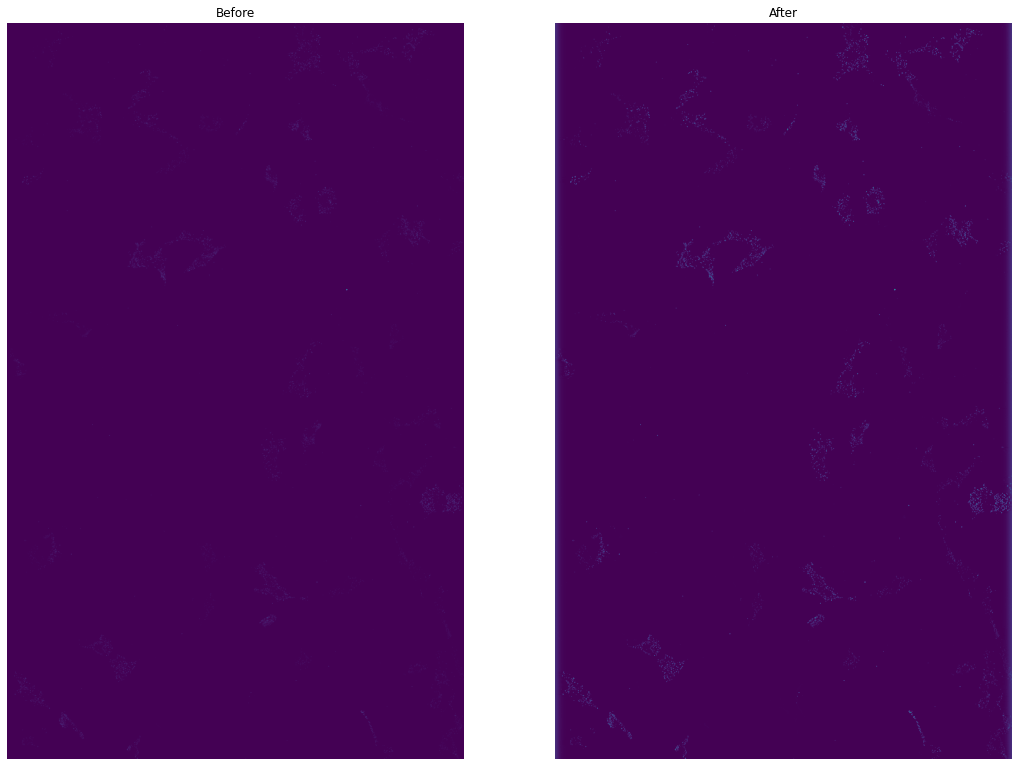

<Figure size 600x400 with 0 Axes>

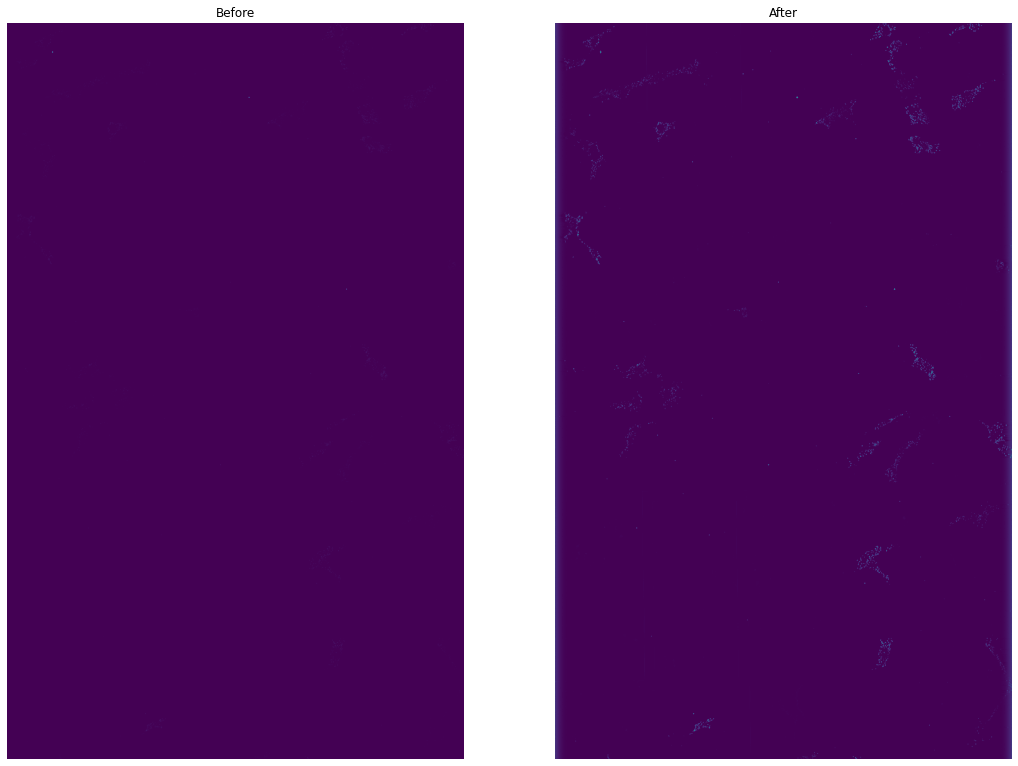

<Figure size 600x400 with 0 Axes>

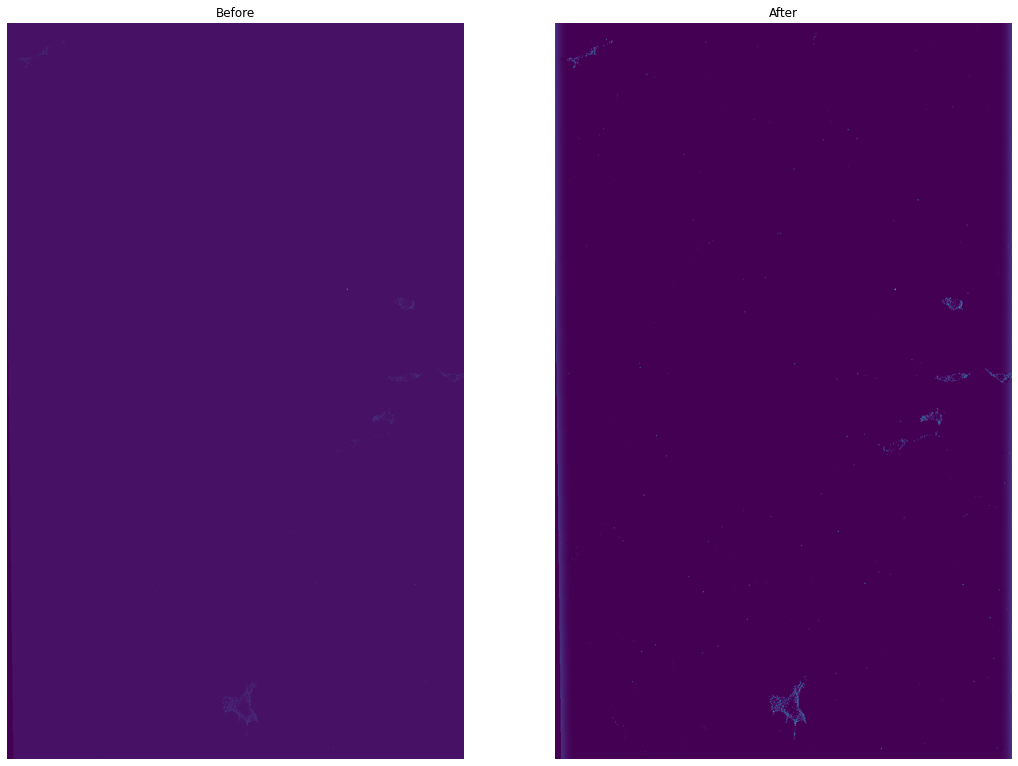

<Figure size 600x400 with 0 Axes>

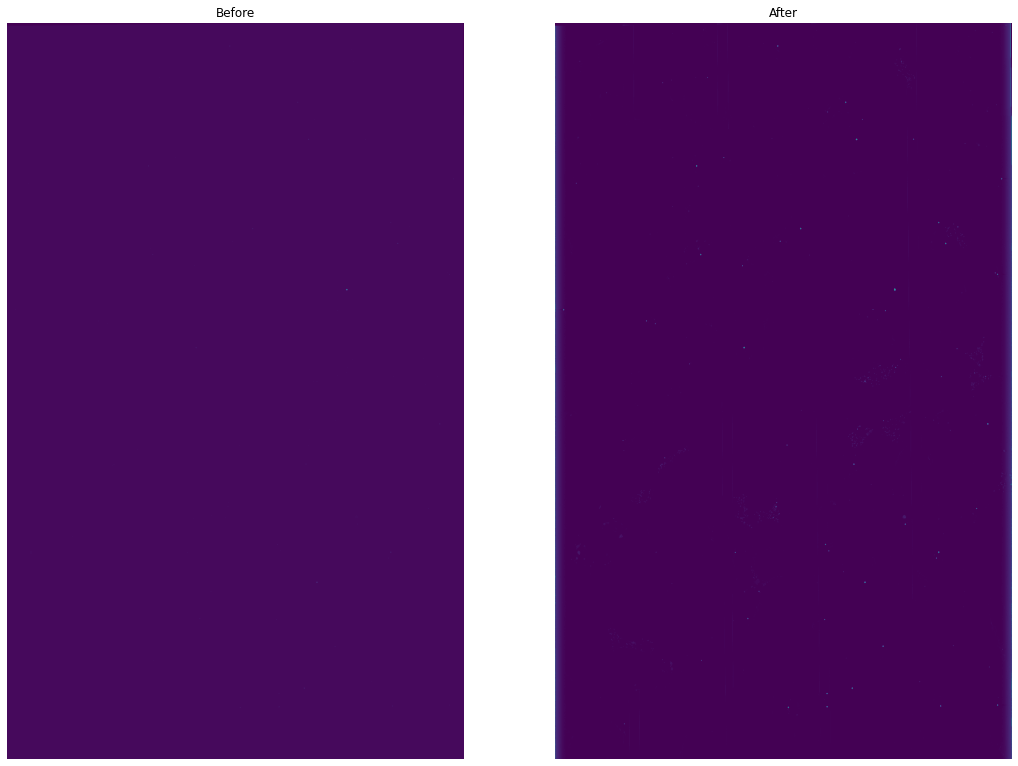

In [367]:
for i in range(Xthresh.shape[0]):
    plt.figure(dpi=100)
    fig, axes = plt.subplots(ncols=2, figsize=(18, 18))
    ax = axes.ravel()

#     ax[0].imshow(Xcenter[i, 0, 400:600, 400:600])
    ax[0].imshow(Xcenter[i, 0])
    ax[0].set_title('Before')

#     ax[1].imshow(Xthresh[i, 0, 400:600, 400:600])
    ax[1].imshow(Xthresh[i, 0])
    ax[1].set_title('After')

    for a in ax:
        a.axis('off')

    plt.show()

## Prediction

In [368]:
# Read in the membrane segmentation
with open('./data/20210714masks_mem.npy', 'rb') as m:
    masks_mem = np.load(m)

In [369]:
cell_table = dcp.create_celltable(Xthresh, masks_mem, up_adjust=up, left_adjust=left)
cell_table

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 8., 1., ..., 9., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [370]:
# pd.DataFrame(cell_table).to_csv('./result/crisprmap20210714sg2NEB_cell_table.csv')

In [371]:
cell_table.shape

(336, 10)

In [372]:
cell_corr = dcp.cal_metric(cell_table, codebook)
corr_thresh = 0.001
alpha = 0.05  
beta = 0.8  # power
thresh_corr_diff = 0.26
cell_id = pd.DataFrame(dcp.argmax_thresh(cell_corr, axis=1, thresh=corr_thresh), columns=['barcode'])
cell_id['correlation_max'] = dcp.minmax(np.max(cell_corr, axis=1), min_all=np.min(cell_corr), max_all=np.max(cell_corr))
cell_id['correlation_2nd_max'] = dcp.minmax([heapq.nlargest(2, cell_corr[i,])[1] for i in cell_id.index], min_all=np.min(cell_corr), max_all=np.max(cell_corr))
cell_id['correlation_difference'] = cell_id['correlation_max'] - cell_id['correlation_2nd_max']
cell_id['select_by_correlation'] = cell_id['correlation_difference'] > thresh_corr_diff
cell_id['spots_max'] = np.max(cell_table, axis=1)
cell_id['spots_sum'] = np.sum(cell_table, axis=1)
cell_id['spots_needed'] = cell_id['correlation_max'].apply(dcp.sample_size, alpha=alpha, beta=beta)
cell_id['select_by_spots'] = cell_id['spots_sum'] > cell_id['spots_needed']
cell_id['selected'] = cell_id['select_by_correlation'] & cell_id['select_by_spots']
cell_id.head()

,barcode,correlation_max,correlation_2nd_max,correlation_difference,select_by_correlation,spots_max,spots_sum,spots_needed,select_by_spots,selected
0,-1,0.000000,0.000000,0.000000,False,0.0,0.0,31395550336760,False,False
1,3,0.707106,0.000000,0.707106,True,1.0,1.0,13,False,False
2,9,0.978240,0.575435,0.402805,True,9.0,21.0,4,True,True
3,0,0.816496,0.816496,0.000000,False,3.0,6.0,8,False,False
4,6,0.989950,0.585888,0.404061,True,27.0,55.0,4,True,True


In [373]:
print("The number of cells:", cell_id.shape[0]-1)
cell_no_spots = cell_id[cell_id.barcode==-1].shape[0]
print("The number of cells with no detected spots:", cell_no_spots)
print("Percent of cells with no detected spots:", cell_no_spots / (cell_id.shape[0] -1))
double_infected = cell_id.shape[0] -1 - cell_no_spots - np.sum(cell_id.select_by_correlation)
print("The number of double-infected cells:", double_infected)
print("Percent of double-infected cells:", double_infected / (cell_id.shape[0] -1))
low_spots = cell_id.shape[0] - 1 - np.sum(cell_id.select_by_spots)
# print("The number of cells that do not have enough spots to calculate a significant correlation or no spots:", low_spots)
# print("Percent of cells that do not have enough spots to calculate a significant correlation or no spots:", low_spots / (cell_id.shape[0] -1))
print("The number of cells that do not have enough spots to calculate a significant correlation:", low_spots - cell_no_spots)
print("Percent of cells that do not have enough spots to calculate a significant correlation:", (low_spots- cell_no_spots) / (cell_id.shape[0] -1))
print("The number of cells selected after removing double infection and low number of spots:", np.sum(cell_id.selected))
print("Percent of cells selected after removing double infection and low number of spots:", np.sum(cell_id.selected) / (cell_id.shape[0] -1))

The number of cells: 335
The number of cells with no detected spots: 66
Percent of cells with no detected spots: 0.19701492537313434
The number of double-infected cells: 82
Percent of double-infected cells: 0.24477611940298508
The number of cells that do not have enough spots to calculate a significant correlation: 52
Percent of cells that do not have enough spots to calculate a significant correlation: 0.15522388059701492
The number of cells selected after removing double infection and low number of spots: 162
Percent of cells selected after removing double infection and low number of spots: 0.4835820895522388


In [374]:
# plt.figure(dpi=100)
# sh = sns.histplot(data=cell_id, x="spots_sum", binwidth=1)

In [375]:
# cell_id.to_csv('./result/crisprmap20210714sg2NEB_picklemax_cell_id_all.csv', index=False)

In [376]:
# high_quality = cell_id[cell_id['correlation_difference']>0.26]
# high_quality_mem = np.zeros(masks_mem.shape)
# for i in high_quality.index:
#     high_quality_mem[np.array(masks_mem)==i] = i
# plt.figure(dpi=250)
# plt.imshow(find_boundaries(high_quality_mem), origin='lower')

In [377]:
# high_quality = cell_id[cell_id['correlation_difference']>0]
# high_quality_mem = np.zeros(masks_mem.shape)
# for i in high_quality.index:
#     high_quality_mem[np.array(masks_mem)==i] = i
# plt.figure(dpi=250)
# plt.imshow(find_boundaries(high_quality_mem[up:down, left:right]), origin='lower', cmap='Greens')
# for i in range(Xthresh.shape[0]):
#     plt.imshow(Xthresh[i, 0], alpha=0.2, origin='lower', cmap="Reds")